# Experiment - Decision Tree

In [1]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve,  accuracy_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

### Stock Prices

In [3]:
data = pd.read_csv('Feature_Engineering.csv', index_col= None ,engine = 'python')
data.set_index(["ticker", pd.DatetimeIndex(data['date'])], inplace = True, 
                            append = True, drop = True)
data = data.drop(['date'],axis=1)
y = data.returns
X = data.drop('returns', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27548 entries, (0, 'UNH', Timestamp('2017-04-20 00:00:00')) to (27547, 'WMT', Timestamp('2020-04-17 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t-5     27548 non-null  float64
 1   t-20    27548 non-null  float64
dtypes: float64(2)
memory usage: 789.0+ KB


### Binary Outcome

In [4]:
y_binary = (y>0).astype(int)
y_binary

       ticker  date      
0      UNH     2017-04-20    1
1      V       2017-04-20    1
2      VZ      2017-04-20    0
3      WBA     2017-04-20    1
4      WMT     2017-04-20    1
                            ..
27543  MMM     2020-04-17    1
27544  MRK     2020-04-17    1
27545  MSFT    2020-04-17    1
27546  VZ      2020-04-17    1
27547  WMT     2020-04-17    0
Name: returns, Length: 27548, dtype: int32

### 2 Lags Only

In [5]:
X2 = X.loc[:, ['t-5', 't-20']]
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27548 entries, (0, 'UNH', Timestamp('2017-04-20 00:00:00')) to (27547, 'WMT', Timestamp('2020-04-17 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t-5     27548 non-null  float64
 1   t-20    27548 non-null  float64
dtypes: float64(2)
memory usage: 2.0+ MB


## Explore Data

In [6]:
y.describe(percentiles=np.arange(.1, .91, .1).round(1))

count    27548.000000
mean         0.000460
std          0.006748
min         -0.019581
10%         -0.008097
20%         -0.003445
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.001696
80%          0.005125
90%          0.009583
max          0.018930
Name: returns, dtype: float64

## Simple Regression Tree

### Configure Tree

In [10]:
import os
os.environ["PATH"] += os.pathsep +'C:/Users/Elid-PC.DESKTOP-MG9DS93/Anaconda3/Library/bin/graphviz/'

In [11]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=4,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    presort=False)

### Train Decision Tree

In [12]:
reg_tree_t2.fit(X=X2, y=y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=42, splitter='best')

### Visualize Tree

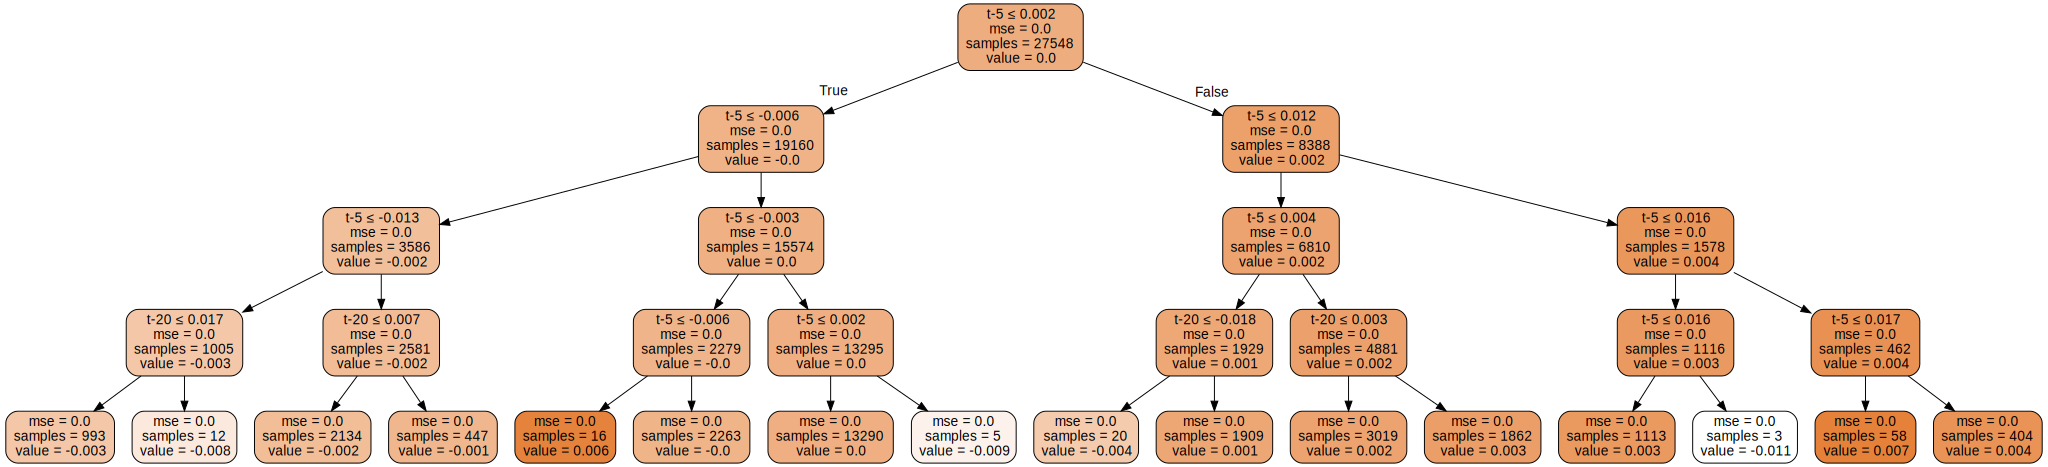

In [13]:
out_file = 'figures/reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=10,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

#### statsmodels OLS

In [14]:
ols_model = sm.OLS(endog=y, exog=sm.add_constant(X2)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     627.5
Date:                Sun, 17 May 2020   Prob (F-statistic):          3.24e-267
Time:                        16:48:35   Log-Likelihood:                 99226.
No. Observations:               27548   AIC:                        -1.984e+05
Df Residuals:                   27545   BIC:                        -1.984e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   3.99e-05      8.874      0.0

### Compare with Linear Time Series Models

#### statsmodels AR(2) Model

Coefficients slighty different because AR model treats returns as a single time series instead creating groups by ticker.

In [15]:
ar_model = sm.tsa.ARMA(endog=y, order=(2,0)).fit()

In [16]:
pd.DataFrame({'AR(2)': ar_model.params.values, 
              'OLS': ols_model.params.values}, 
             index=ols_model.params.index)

,AR(2),OLS
const,0.000460,0.000354
t-5,0.188720,0.205361
t-20,0.192433,0.024139


In [17]:
ar_preds = ar_model.predict()

#### ARMA(2,2)

In [18]:
arma_model = sm.tsa.ARMA(endog=y, order=(2, 2)).fit()
print(arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                27548
Model:                     ARMA(2, 2)   Log Likelihood              100638.171
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 17 May 2020   AIC                        -201264.341
Time:                        16:49:17   BIC                        -201214.999
Sample:                             0   HQIC                       -201248.445
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      4.462      0.000       0.000       0.001
ar.L1.returns     1.8075      0.026     68.523      0.000       1.756       1.859
ar.L2.returns    -0.8217      0.025    -

In [19]:
arma_preds = arma_model.predict()

In [20]:
preds = X2.assign(arma=arma_preds, ar=ar_preds).sample(frac=.1).sort_values(['t-5', 't-20'])
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2755 entries, (18077, 'AAPL', Timestamp('2019-03-23 00:00:00')) to (9903, 'XOM', Timestamp('2018-04-05 00:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t-5     2755 non-null   float64
 1   t-20    2755 non-null   float64
 2   arma    2755 non-null   float64
 3   ar      2755 non-null   float64
dtypes: float64(4)
memory usage: 323.6+ KB


In [21]:
q = 4
preds['t-5q'] = pd.qcut(preds['t-5'], q=q, labels=list(range(1, q+1)), duplicates='drop').astype(int)
preds['t-20q'] = pd.qcut(preds['t-20'], q=q, labels=list(range(1, q+1))).astype(int)

#### Decision Surfaces

The plot of the decision surface for both time series models illustrates how the ARMA model is capable of representing a more complex dynamic relationship.

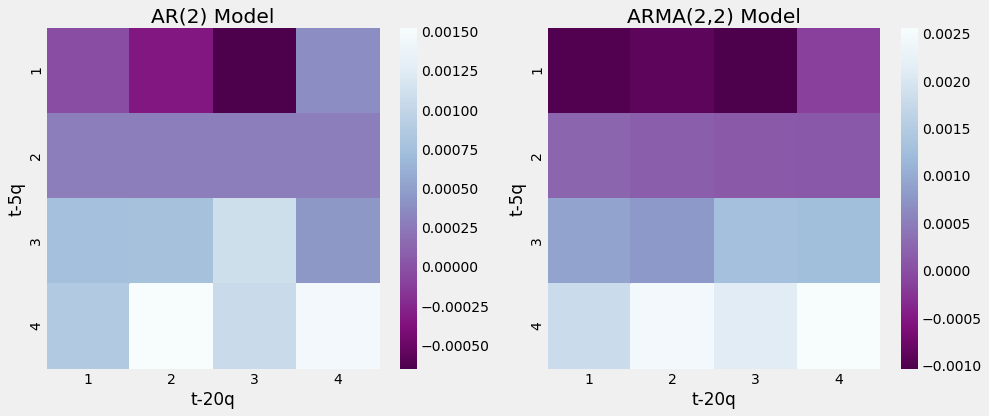

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.heatmap(preds.groupby(['t-5q', 't-20q']).ar.median().unstack(), ax=axes[0], cmap='BuPu_r')
axes[0].set_title('AR(2) Model')
sns.heatmap(preds.groupby(['t-5q', 't-20q']).arma.median().unstack(), ax=axes[1], cmap='BuPu_r')
axes[1].set_title('ARMA(2,2) Model')
fig.tight_layout();

### sklearn Linear Regression

In [23]:
lin_reg = LinearRegression()

In [24]:
# %%timeit
lin_reg.fit(X=X2,y=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
lin_reg.intercept_

0.00035433473120230935

In [26]:
lin_reg.coef_

array([0.2053612 , 0.02413856])

### Linear Regression vs Regressin Tree Decision Surfaces

In [27]:
t1, t2 = np.meshgrid(np.linspace(X2['t-5'].quantile(.01), X2['t-5'].quantile(.99), 100),
                     np.linspace(X2['t-20'].quantile(.01), X2['t-20'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

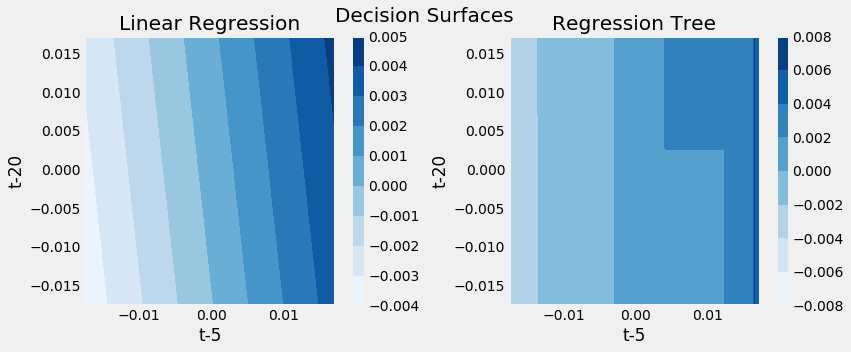

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
# surface2 = axes[1].contourf(t1, t2, np.clip(ret2, a_min=-.05, a_max=.05), cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-5')
    ax.set_ylabel('t-20')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree

### Loss Functions

In [29]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

In [30]:
def gini(f):
    return 2*f*(1-f)

In [31]:
def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

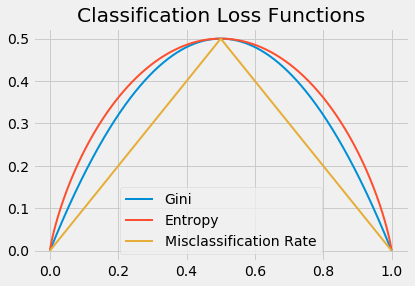

In [32]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2));

#### Compare computation time

Gini is often preferred over entropy because it computes faster:

In [33]:
%%timeit
misclassification_rate(x)

18.3 µs ± 762 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [34]:
%%timeit
gini(x)

14.3 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
%%timeit
entropy(x)

241 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Configure Tree

In [36]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=4,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None,
                                     presort=False)

### Train Tree

In [37]:
# %%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### Visualize Tree

In [38]:
out_file = 'figures/clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file,
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=10,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

g = graphviz.Source(dot_data,format="png")
g.render()

'Source.gv.png'

### Compare with Logistic Regression

#### Statsmodels

In [39]:
model = sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.633783
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:                27548
Model:                          Logit   Df Residuals:                    27545
Method:                           MLE   Df Model:                            2
Date:                Sun, 17 May 2020   Pseudo R-squ.:                 0.02246
Time:                        16:49:50   Log-Likelihood:                -17459.
converged:                       True   LL-Null:                       -17861.
Covariance Type:            nonrobust   LLR p-value:                6.050e-175
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6595      0.013    -50.587      0.000      -0.685      -0.634
t-5           53.5687      1.

#### sklearn

In [40]:
logistic_reg = LogisticRegression()

In [41]:
# %%timeit
logistic_reg.fit(X=X2, y=y_binary)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
logistic_reg.coef_

array([[11.54895035,  2.131106  ]])

### Plot Decision Surfaces

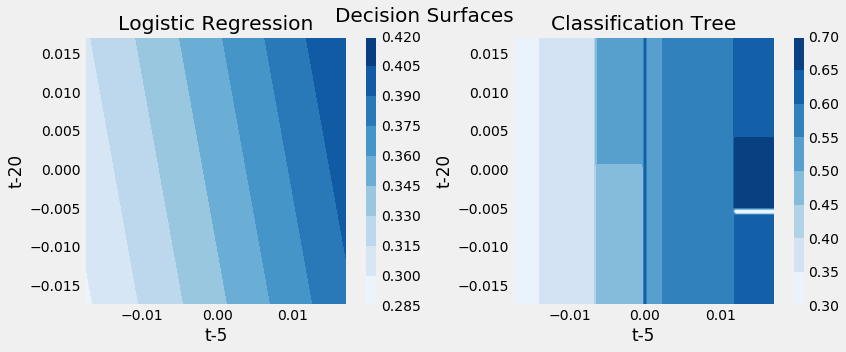

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = logistic_reg.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-5')
    ax.set_ylabel('t-20')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Regression Tree with all Features

### Train-Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
print( y_test)

       ticker  date      
27412  XOM     2020-09-04   -0.016420
22613  DIS     2019-09-16   -0.016085
26600  AAPL    2020-02-15    0.000000
18602  KO      2019-11-04    0.001501
1837   MCD     2017-06-27   -0.001559
                               ...   
19155  XOM     2019-02-05   -0.017541
2616   AAPL    2017-07-26    0.004714
17539  INTC    2019-02-03    0.000000
3287   MSFT    2017-08-19    0.000000
2638   V       2017-07-26    0.008601
Name: returns, Length: 5510, dtype: float64


### Configure Tree

In [46]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

### Train Model

In [47]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=42, splitter='best')

### Visualize Tree

The result shows that the model uses a variety of different features and indicates the split rules for both continuous and categorical (dummy) variables. 

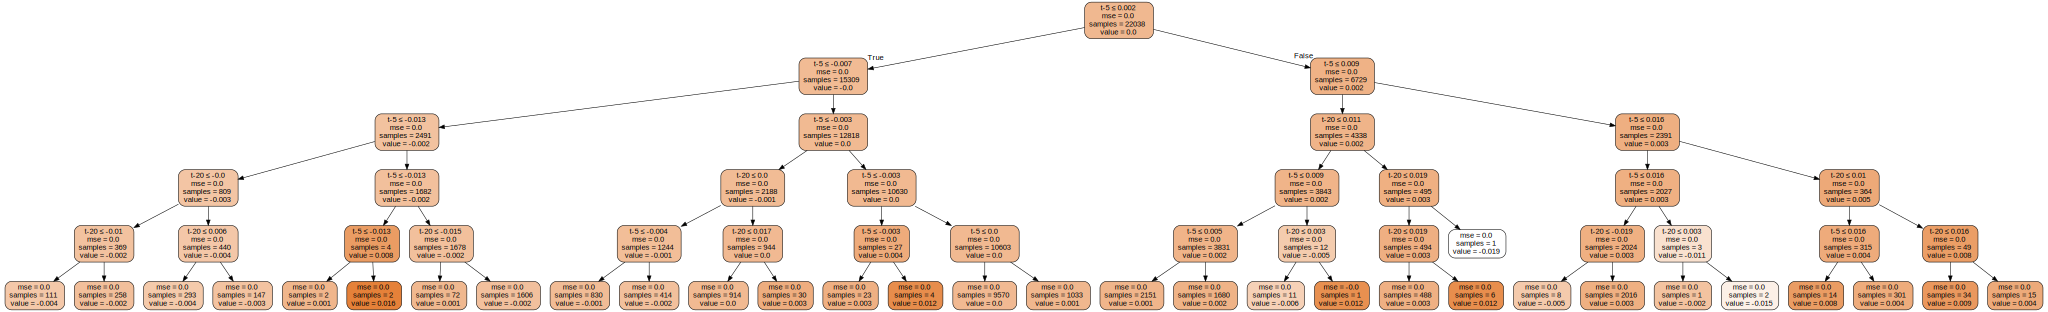

In [48]:
out_file = 'figures/reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file,
                           feature_names=X_train.columns,
                           max_depth=10,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [49]:
y_pred = regression_tree.predict(X_test)

In [50]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.006576971531461803

## Classification Tree with all Features

### Train-Test Split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [52]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [53]:
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [54]:
y_score = clf.predict_proba(X=X_test)[:, 1]

In [55]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.7741661860429204

### Plot Tree

### Evaluate Test Set

In [56]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [57]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.7741661860429204

### Print Decision Path

In [59]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [60]:
tree_to_code(clf_tree_t2, X2.columns)

def tree(t-5, t-20):
   if t-5 <= 0.00%
     if t-5 <= -0.00%
       if t-5 <= -0.65%
         if t-5 <= -1.38%
           return 31.80%
         else:  # if t-5 > -1.38%
           return 39.36%
       else:  # if t-5 > -0.65%
         if t-20 <= 0.06%
           return 45.35%
         else:  # if t-20 > 0.06%
           return 50.13%
     else:  # if t-5 > -0.00%
       if t-20 <= 0.00%
         if t-20 <= -0.00%
           return 1.85%
         else:  # if t-20 > -0.00%
           return 6.38%
       else:  # if t-20 > 0.00%
         if t-20 <= 1.29%
           return 2.51%
         else:  # if t-20 > 1.29%
           return 0.47%
   else:  # if t-5 > 0.00%
     if t-5 <= 1.19%
       if t-5 <= 0.24%
         if t-5 <= 0.02%
           return 62.71%
         else:  # if t-5 > 0.02%
           return 52.58%
       else:  # if t-5 > 0.24%
         if t-5 <= 1.18%
           return 58.02%
         else:  # if t-5 > 1.18%
           return 21.43%
     else:  # if t-5 > 1.19%
       if t